In [1]:
import pandas as pd
import gc
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font="IPAexGothic",style="white")
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
import numpy as np
from IPython.display import Image, display_png

#追加するモデル(これが今回改善に使うモデルです)
from sklearn.ensemble import RandomForestRegressor  as RFR

#パラメータ探索を行う場合
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
# 現在の最大表示列数の出力
pd.get_option("display.max_columns")
# 最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

In [3]:
train = pd.read_csv('C:/Users/yoshinaga/Desktop/shinn/情報工学/python/191110/データ/train.csv',index_col=['datetime'])
test = pd.read_csv('C:/Users/yoshinaga/Desktop/shinn/情報工学/python/191110/データ/test.csv',index_col=['datetime'])
y_test=pd.read_csv('C:/Users/yoshinaga/Desktop/shinn/情報工学/python/191110/データ/sample.csv')
print(test.shape)
print(y_test.shape)

(40, 10)
(39, 2)


In [4]:
train.tail(20)

,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
datetime,,,,,,,,,,,
2014-9-1,65,月,1,ビーフシチュー,380.0,NaN,NaN,NaN,曇,--,23.4
2014-9-2,68,火,1,名古屋味噌カツ,440.0,手作りの味,NaN,NaN,晴れ,--,29.1
2014-9-3,53,水,0,親子煮,408.0,NaN,NaN,NaN,曇,--,26.7
2014-9-4,54,木,1,チキンステーキ・きのこソース,405.0,NaN,NaN,NaN,曇,0,26.5
2014-9-5,43,金,0,メンチカツ,380.0,NaN,NaN,NaN,晴れ,--,30.2
2014-9-8,68,月,1,鶏肉の山賊焼き,385.0,NaN,NaN,NaN,曇,--,23.1
2014-9-9,63,火,0,ハンバーグデミソース,460.0,NaN,NaN,NaN,晴れ,--,26.8
2014-9-10,54,水,0,ぶりレモンペッパー焼き,450.0,NaN,NaN,1.0,曇,0,25.0
2014-9-11,53,木,0,手作りチキンカツ,385.0,NaN,NaN,NaN,曇,--,21.9


In [5]:
test.head()

,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
datetime,,,,,,,,,,
2014-10-1,水,1,メンチカツ,420.0,NaN,NaN,NaN,雨,0,20.2
2014-10-2,木,0,バーベキューチキン,415.0,NaN,NaN,NaN,曇,--,23.9
2014-10-3,金,0,豚肉のマスタード焼き,405.0,NaN,NaN,NaN,晴れ,--,28.7
2014-10-6,月,1,麻婆春雨,400.0,NaN,NaN,NaN,雨,0.5,21.5
2014-10-7,火,0,厚揚げ肉みそ炒め,430.0,NaN,NaN,NaN,晴れ,--,22.1


In [6]:
# (行数,カラム数)
train.shape

(207, 11)

In [7]:
# (行数,カラム数)
test.shape

(40, 10)

In [8]:
# フラグを立てる
train['flg'] = 1
test['flg'] = 0
# trainデータとtestデータを結合
all_data = pd.concat([train,test], axis=0, sort=False)

In [9]:
# 欠損数、型確認
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247 entries, 2013-11-18 to 2014-11-28
Data columns (total 12 columns):
y                207 non-null float64
week             247 non-null object
soldout          247 non-null int64
name             247 non-null object
kcal             202 non-null float64
remarks          28 non-null object
event            17 non-null object
payday           12 non-null float64
weather          247 non-null object
precipitation    247 non-null object
temperature      247 non-null float64
flg              247 non-null int64
dtypes: float64(4), int64(2), object(6)
memory usage: 25.1+ KB


In [10]:
# 各カラムの統計量を見る
all_data.describe()

,y,soldout,kcal,payday,temperature,flg
count,207.000000,247.000000,202.000000,12.0,247.000000,247.000000
mean,86.623188,0.445344,407.381188,1.0,19.157085,0.838057
std,32.882448,0.498013,28.396942,0.0,8.075680,0.369147
min,29.000000,0.000000,315.000000,1.0,1.200000,0.000000
25%,57.000000,0.000000,395.000000,1.0,13.650000,1.000000
50%,78.000000,0.000000,412.000000,1.0,19.400000,1.000000
75%,113.000000,1.000000,427.000000,1.0,25.450000,1.000000
max,171.000000,1.000000,462.000000,1.0,34.600000,1.000000


In [11]:
all_data.loc[all_data['kcal'].isnull()  , ['week', 'kcal','y']]

,week,kcal,y
datetime,,,
2013-11-18,月,NaN,90.0
2013-11-19,火,NaN,101.0
2013-11-20,水,NaN,118.0
2013-11-21,木,NaN,120.0
2013-11-22,金,NaN,130.0
2013-11-25,月,NaN,135.0
2013-11-26,火,NaN,145.0
2013-11-27,水,NaN,140.0
2013-11-28,木,NaN,151.0


In [12]:
all_data.loc[all_data['week'] == '金'  , ['week', 'kcal', 'remarks','y']]

,week,kcal,remarks,y
datetime,,,,
2013-11-22,金,NaN,NaN,130.0
2013-11-29,金,NaN,NaN,116.0
2013-12-6,金,NaN,NaN,134.0
2013-12-13,金,NaN,NaN,111.0
2013-12-20,金,NaN,NaN,134.0
2014-1-10,金,440.0,NaN,87.0
2014-1-17,金,430.0,NaN,85.0
2014-1-24,金,418.0,鶏のレモンペッパー焼（50食）、カレー（42食）,92.0
2014-1-31,金,460.0,NaN,92.0


In [13]:
all_data['kcal'].describe()

count    202.000000
mean     407.381188
std       28.396942
min      315.000000
25%      395.000000
50%      412.000000
75%      427.000000
max      462.000000
Name: kcal, dtype: float64

In [14]:
all_data['kcal'] = all_data['kcal'].fillna(train['kcal'].mean())
all_data['kcal'].head()

datetime
2013-11-18    404.409639
2013-11-19    404.409639
2013-11-20    404.409639
2013-11-21    404.409639
2013-11-22    404.409639
Name: kcal, dtype: float64

In [15]:
print(train.payday.unique())
all_data.loc[~all_data['payday'].isnull() , ['week', 'payday']]

[nan  1.]


,week,payday
datetime,,
2013-12-10,火,1.0
2014-1-10,金,1.0
2014-2-10,月,1.0
2014-3-10,月,1.0
2014-4-10,木,1.0
2014-5-9,金,1.0
2014-6-10,火,1.0
2014-7-10,木,1.0
2014-8-8,金,1.0


In [16]:
all_data['payday'] = all_data['payday'].fillna(0)
all_data['payday'].unique()

array([0., 1.])

In [17]:
all_data['event'] = all_data['event'].fillna('なし')
all_data['event'].unique()

array(['なし', 'ママの会', 'キャリアアップ支援セミナー'], dtype=object)

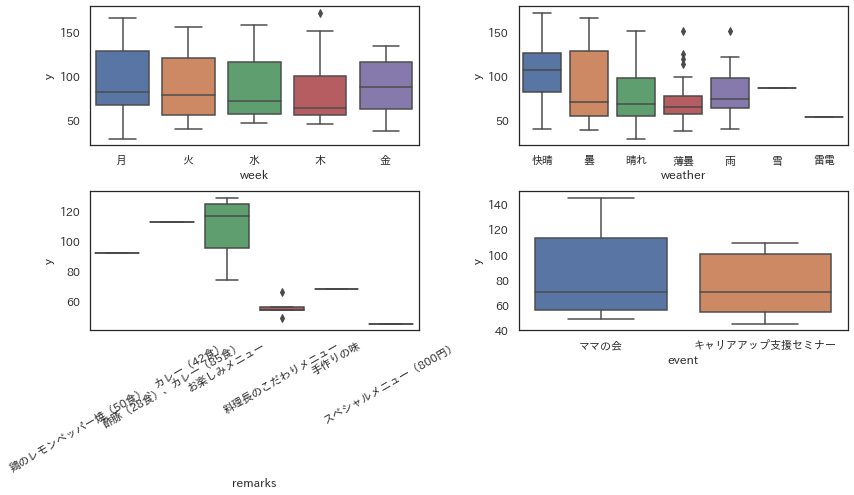

In [18]:
fig, ax = plt.subplots(2,2,figsize=(12,7))
sns.boxplot(x="week",y="y",data=train,ax=ax[0][0])
sns.boxplot(x="weather",y="y",data=train,ax=ax[0][1])
sns.boxplot(x="remarks",y="y",data=train,ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(),rotation=30)
sns.boxplot(x="event",y="y",data=train,ax=ax[1][1])
plt.tight_layout()

In [19]:
all_data.loc[all_data['remarks'] != 'お楽しみメニュー', 'remarks'] = 'なし'
all_data['remarks'].unique()

array(['なし', 'お楽しみメニュー'], dtype=object)

In [20]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247 entries, 2013-11-18 to 2014-11-28
Data columns (total 12 columns):
y                207 non-null float64
week             247 non-null object
soldout          247 non-null int64
name             247 non-null object
kcal             247 non-null float64
remarks          247 non-null object
event            247 non-null object
payday           247 non-null float64
weather          247 non-null object
precipitation    247 non-null object
temperature      247 non-null float64
flg              247 non-null int64
dtypes: float64(4), int64(2), object(6)
memory usage: 35.1+ KB


In [21]:
all_data[['weather', 'precipitation']].tail(30)

,weather,precipitation
datetime,,
2014-10-16,晴れ,--
2014-10-17,快晴,--
2014-10-20,薄曇,--
2014-10-21,雨,0
2014-10-22,雨,0
2014-10-23,雨,0.5
2014-10-24,快晴,--
2014-10-27,薄曇,--
2014-10-28,快晴,--


In [22]:
# 降水量が--の時
all_data[all_data['precipitation'] == "--"]['weather'].unique()

array(['快晴', '曇', '晴れ', '薄曇'], dtype=object)

In [23]:
# 降水量が0の時
all_data[all_data['precipitation'] == "0"]['weather'].unique()

array(['雨', '曇', '雷電', '薄曇'], dtype=object)

In [24]:
# 降水量に数値が入っている時
all_data[~(all_data['precipitation'] == '0') & ~(all_data['precipitation'] == '--')]['weather'].unique()

array(['曇', '雨', '雪'], dtype=object)

In [25]:
# precipitation_flg(カテゴリ変数)
all_data['precipitation_flg'] = '悪い'
all_data.loc[(all_data['precipitation'] == '--'), 'precipitation_flg'] = '良い'
all_data.loc[(all_data['precipitation'] == '0'), 'precipitation_flg'] = 'やや悪い'

In [26]:
# 文字列を数値データに変える(量的変数)
all_data['precipitation'] = all_data['precipitation'].replace('--', '-1')

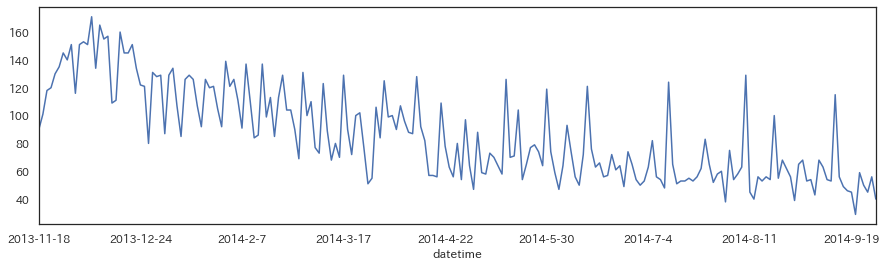

In [27]:
train["y"].plot(figsize=(15,4))

In [28]:
# 経過日数カラムを作成
all_data['days'] = range(1,len(all_data)+1)

In [29]:
# 各カラムの一意の値を見る
for col in all_data.columns:
    print(col,all_data[col].unique())
    print(all_data[col].nunique())
    print('----------------------------------------------')

y [ 90. 101. 118. 120. 130. 135. 145. 140. 151. 116. 153. 171. 134. 165.
 155. 157. 109. 111. 160. 122. 121.  80. 131. 128. 129.  87. 107.  85.
 126.  92. 105. 139.  91. 137.  84.  86.  99. 113. 104.  69. 100. 110.
  77.  73. 123.  89.  68.  70.  72. 102.  51.  55. 106. 125.  96.  88.
  82.  57.  56.  78.  63.  54.  97.  64.  47.  59.  58.  71.  65.  79.
  74. 119.  93.  50.  76.  66.  61.  49.  53.  48. 124.  62.  83.  52.
  60.  38.  75.  45.  40.  39.  43. 115.  46.  29.  nan]
94
----------------------------------------------
week ['月' '火' '水' '木' '金']
5
----------------------------------------------
soldout [0 1]
2
----------------------------------------------
name ['厚切りイカフライ' '手作りヒレカツ' '白身魚唐揚げ野菜あん' '若鶏ピリ辛焼' 'ビッグメンチカツ' '鶏の唐揚' '豚のスタミナ炒め'
 'ボローニャ風カツ' 'ハンバーグ' 'タルタルinソーセージカツ' 'マーボ豆腐' '厚揚げ豚生姜炒め' 'クリームチーズ入りメンチ'
 '鶏のカッシュナッツ炒め' '手作りロースカツ' 'ハンバーグデミソース' 'やわらかロースのサムジョン' '五目御飯' '肉じゃが'
 'タンドリーチキン' 'カキフライタルタル' '回鍋肉' 'ポーク味噌焼き' '鶏の唐揚げ甘酢あん' 'さっくりメンチカツ'
 '手ごね風ハンバーグ' '酢豚' 'カレー入りソーセージカツ' '豚肉の生姜焼' '鶏チ

In [30]:
all_data[['week']].head(10)

,week
datetime,
2013-11-18,月
2013-11-19,火
2013-11-20,水
2013-11-21,木
2013-11-22,金
2013-11-25,月
2013-11-26,火
2013-11-27,水
2013-11-28,木


In [31]:
# One-Hotエンコーダー
ohe_columns = ['week','soldout','remarks','event','payday','weather','precipitation_flg']

all_data = pd.get_dummies(all_data, dummy_na=False, columns=ohe_columns)

In [32]:
all_data[['week_月','week_火','week_水','week_木','week_金',]].head(10)

,week_月,week_火,week_水,week_木,week_金
datetime,,,,,
2013-11-18,1,0,0,0,0
2013-11-19,0,1,0,0,0
2013-11-20,0,0,1,0,0
2013-11-21,0,0,0,1,0
2013-11-22,0,0,0,0,1
2013-11-25,1,0,0,0,0
2013-11-26,0,1,0,0,0
2013-11-27,0,0,1,0,0
2013-11-28,0,0,0,1,0


In [33]:
# trainとtestにわける
train = all_data.query('flg == 1')
test = all_data.query('flg == 0')

In [34]:
train.drop(['flg','name'], axis=1,inplace=True)
test.drop(['flg','name','y'], axis=1,inplace=True)

C:\Users\yoshinaga\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [35]:
train.head()

,y,kcal,precipitation,temperature,days,week_月,week_木,week_水,week_火,week_金,soldout_0,soldout_1,remarks_お楽しみメニュー,remarks_なし,event_なし,event_キャリアアップ支援セミナー,event_ママの会,payday_0.0,payday_1.0,weather_快晴,weather_晴れ,weather_曇,weather_薄曇,weather_雨,weather_雪,weather_雷電,precipitation_flg_やや悪い,precipitation_flg_悪い,precipitation_flg_良い
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-18,90.0,404.409639,-1,19.8,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2013-11-19,101.0,404.409639,-1,17.0,2,0,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2013-11-20,118.0,404.409639,-1,15.5,3,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2013-11-21,120.0,404.409639,-1,15.2,4,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2013-11-22,130.0,404.409639,-1,16.1,5,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1


In [36]:
# display_png(Image("C:/Users/yoshinaga/Desktop/shinn/情報工学/python/191110
# /RF_1.png", width=300, height=200,))

In [37]:
# trainデータの説明変数と目的変数をわける
linear_X_train = train[["days", "temperature", "kcal", "remarks_お楽しみメニュー", "remarks_なし"
                       ,"week_月", "week_火", "week_水", "week_木", "week_金", "weather_雨","soldout_1"
                      ,"precipitation_flg_やや悪い","precipitation_flg_悪い"]]

# 目的変数はLinear,RandomForest共通
y_train = train['y']

# testデータもlinear_X_trainと同じカラムにする
linear_test = test[["days", "temperature", "kcal", "remarks_お楽しみメニュー", "remarks_なし"
                 ,"week_月", "week_火", "week_水", "week_木", "week_金", "weather_雨","soldout_1"
                ,"precipitation_flg_やや悪い","precipitation_flg_悪い"]]

print(linear_test.shape)

(40, 14)


In [38]:
# LinearRegressionのパラメータ設定
linear = LinearRegression()

#ランダムフォレストのモデル定義(ハイパーパラメータは適当な状態)
rg=RFR(n_jobs=-1,random_state=2525,min_samples_split=50,max_depth=50)

In [39]:
# 線形回帰モデル作成
# linear.fit(linear_X_train,y_train)
rg.fit(linear_X_train,y_train)

# 予測
# pred = linear.predict(linear_X_train)
pred=rg.predict(linear_X_train)

C:\Users\yoshinaga\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE 15.973739108007747
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=2525, verbose=0,
                      warm_start=False)


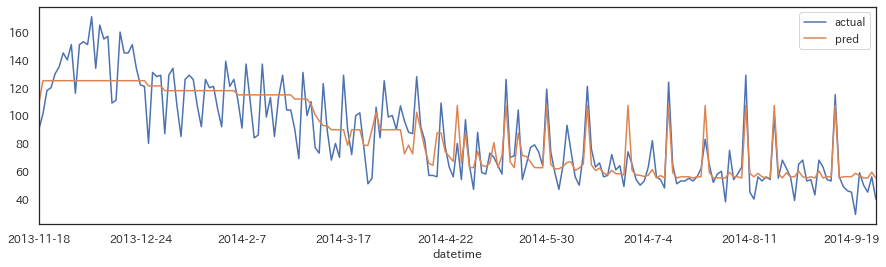

In [40]:
# y_trainと予測値のRMSEを出す
print("RMSE",np.sqrt(MSE(y_train,pred)))

# 線形回帰の予測値と実数値のグラフ
p = pd.DataFrame({"actual":y_train,"pred":pred})
p.plot(figsize=(15,4))


#テストデータで評価する
preTest=rg.predict(linear_test)

#初期のランダムフォレストモデルのパラメータ確認
print(rg)

In [41]:
#以下はモデルのハイパーパラメータを交差検証法で改善する

# サーチするパラメータのグリッド
search_params = {
    'n_estimators'      : [1, 5, 10, 20, 30, 50, 100],
    'max_features'      : [i for i in range(1,linear_X_train.shape[1])],
    'random_state'      : [2525],
    'n_jobs'            : [1],
    'min_samples_split' : [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
    'max_depth'         : [3, 5, 10, 15, 20, 25, 30, 40, 50, 100]
}
#交差検証法のスコア検証
#https://qiita.com/yhyhyhjp/items/c81f7cea72a44a7bfd3a
clf=GridSearchCV(rg,search_params,cv=5,n_jobs=-1,verbose=True)

#モデルフィット
clf.fit(linear_X_train,y_train)

Fitting 5 folds for each of 9100 candidates, totalling 45500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2014 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 8014 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 16414 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 27214 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 40414 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 45500 out of 45500 | elapsed:  1.7min finished
C:\Users\yoshinaga\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=50, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=50,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=-1,
                                             oob_score=False, random_state=2525,
                                             verbo...arm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
                         'max_featu

In [42]:
#ベストパラメータのモデル
print(clf.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
                      oob_score=False, random_state=2525, verbose=0,
                      warm_start=False)


RMSE 6.426254071257743


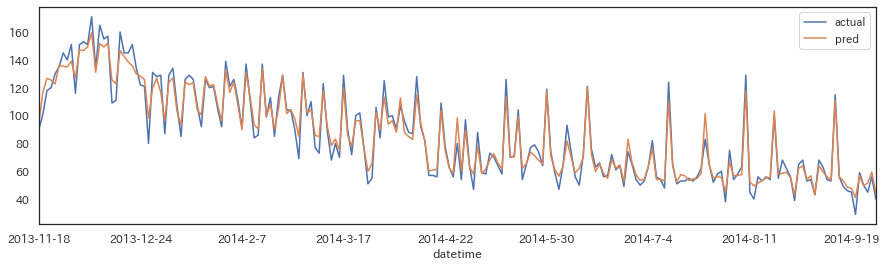

In [45]:
#ベストモデルで予測＆精度確認
pred=clf.best_estimator_.score(linear_X_train,y_train)
#ベストモデルで予測
y_pred=clf.best_estimator_.predict(linear_X_train)
#ベストモデルで精度検証
print("RMSE",np.sqrt(MSE(y_train,y_pred)))
# 実測と予想の比較(グラフで)
p = pd.DataFrame({"actual":y_train,"pred":y_pred})
p.plot(figsize=(15,4))